In [1]:
from glob import glob
import numpy as np

In [2]:
framefiles = sorted(glob('captures/*.jpg'))
print(framefiles[0])

captures\28500.jpg


In [3]:
stripfiles = sorted(glob('meshes/frame*.obj'))
stripfiles = [fl for fl in stripfiles if 't1' not in fl]
print('    ', len(stripfiles))
print(stripfiles[0])
print(stripfiles[-1])

     8170
meshes\frame28500_strip_o100_s20_704.obj
meshes\frame39000_strip_o99_s20_666.obj


In [4]:
def parsev(line, comment=True, dtype=float):
    if comment: line = line.replace('# ', '')
    parts = line.split()
    token = parts[0]
    vlist = [dtype(val) for val in parts[1:]]
    return vlist, token

parsev('# asdf 1 2 3 4')

([1.0, 2.0, 3.0, 4.0], 'asdf')

In [5]:
RSTRIDE = 3
BSTART = 40
def load_markup(fname):
    with open(fname) as fl:
        raw = fl.read()
    lines = [ln for ln in raw.split('\n') if ln]
    registers = lines[1:1+256]
    registers = [parsev(ln)[0] for ln in registers]
    
    vstart, vend, ventries = -1, -1, 1
    vstart = lines.index('# Data:') + 1
    for lii, line in enumerate(lines[vstart:]):
        if line[0] == 'v':
            ventries = lii + 1
            break
    for lii, line in enumerate(lines[vstart:]):
        if line[0] == 'f':
            vend = lii
            break
    vend += vstart
#     print(vstart, vend, ventries)
        
    vgrouped = [lines[lii:lii+ventries] for lii in range(vstart, vend, ventries)]
    faces = [parsev(ln, comment=False, dtype=int)[0] for ln in lines if ln[0] == 'f']
    
    verts = []
    for group in vgrouped:
        ent = {}
        converted = [parsev(line) for line in group[:ventries-1]]
        for vector, token in converted: ent[token] = vector
        
        vertex, _ = parsev(group[-1], comment=False)
        ent['vertex'] = vertex + [1,]
        verts.append(ent)

    for ent in verts:
        vertex = ent['vertex']
        if 'blend' in ent:
            bind = int(ent['blend'][0])
            assert bind >= 0
            boffset = BSTART + RSTRIDE * bind
            bvect = np.zeros(4)
            for dim in range(3):
                bweights = np.array(registers[boffset+dim])
                bvect[dim] = np.dot(vertex, bweights)
            bvect[3] = 1
            ent['world'] = bvect
        else:
            ent['world'] = ent['vertex']
        ent['project'] = np.array([np.dot(ent['world'], registers[rii]) for rii in range(4)])
        ent['project'] /= ent['project'][-1]

    return verts, faces, registers

verts, faces, regs = load_markup(stripfiles[0])
# verts, faces, regs = load_markup('meshes/frame30000_strip_o149_s60_2608.obj')
print(verts[0]['world'])
print(verts[-1]['world'])
print(verts[-1]['project'])
print(faces[0])

[2.61654629e+03 1.34161931e+02 7.02777690e+02 1.00000000e+00]
[2.58501141e+03 1.05473286e+02 6.96195167e+02 1.00000000e+00]
[-1.14657993 -0.38425865  0.96848487  1.        ]
[1, 1, 2]


In [6]:
# def writeobj(fname, verts, faces):
#     with open(fname, 'w') as fl:
#         for ent in verts:
#             fl.write('v %s\n' % ' '.join(['%f' % val for val in ent['world'][:3]]))
#         for fdef in faces:
#             fl.write('f %s\n' % ' '.join(['%d' % val for val in fdef]))

# stripfiles = sorted(glob('meshes/frame*.obj'))
# stripfiles = [fl for fl in stripfiles if 't1' not in fl]

# for fname in stripfiles:
#     verts, faces, regs = load_markup(fname)
#     fname = fname.replace('frame', 'blendf').replace('meshes', 'outputs')
# #     print(fname)
#     writeobj(fname, verts, faces)

captures\28500.jpg
28500     
(768, 1024) 4.509646310859043


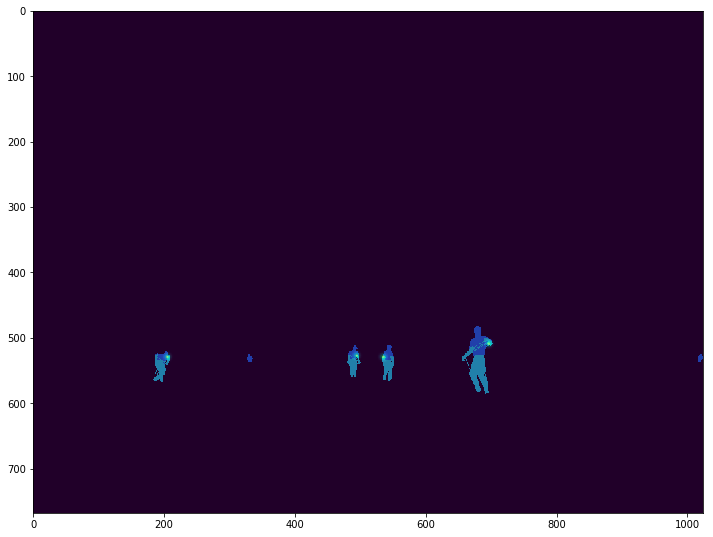

28750     
(768, 1024) 4.509646310859043


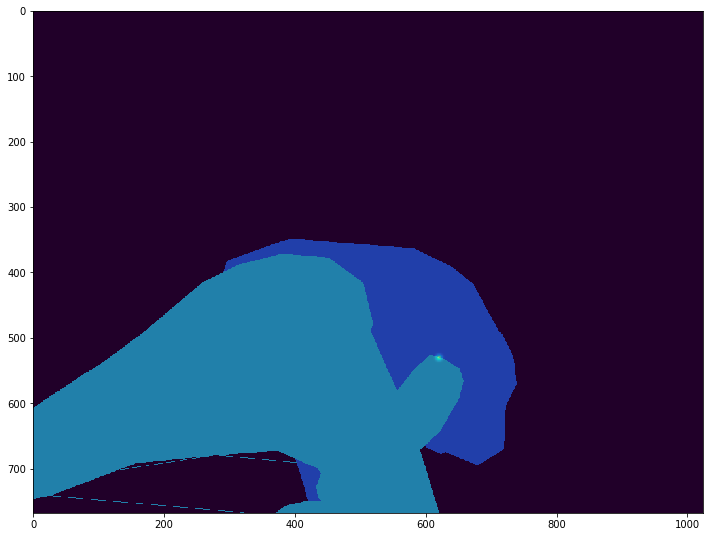

29000     
(768, 1024) 4.509646310859043


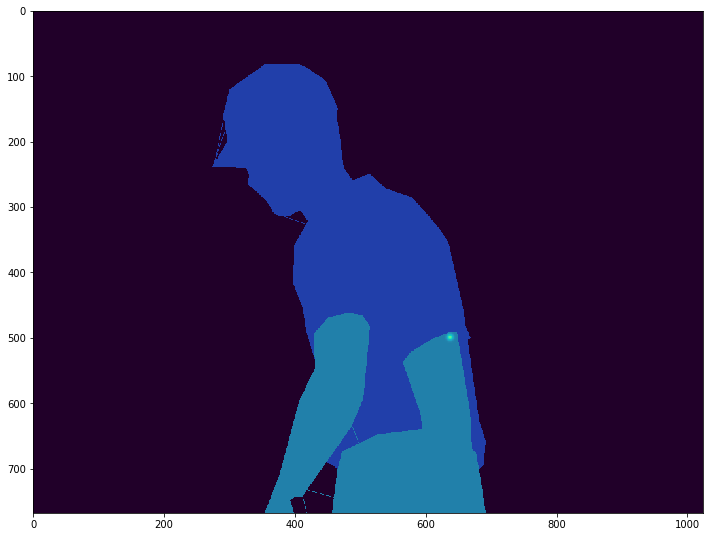

29250     
(768, 1024) 4.509646310859043


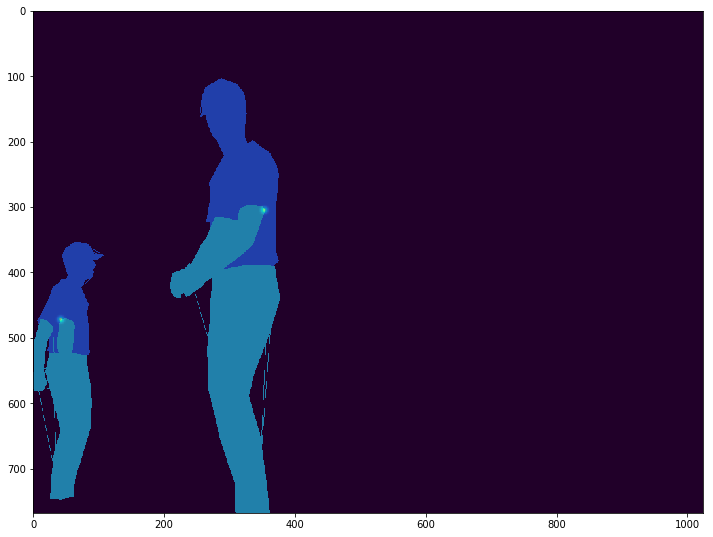

29500     


IndexError: index 1257 is out of bounds for axis 1 with size 1024

In [67]:
from scipy.misc import imsave
import matplotlib.pyplot as plt
import cv2
import sys
from scipy.ndimage import gaussian_filter as blur
    
markupfiles = sorted(glob('meshes/frame*.obj'))
framefiles = sorted(glob('captures/*.jpg'))
print(framefiles[0])

def dump_frame(fcount):
    import sys
    class merged:
        verts = []
        faces = []
    
    foffset = 0
    filtered = [fl for fl in markupfiles if '%d'%fcount in fl]
    for fii, fname in enumerate(filtered):
        verts, faces, regs = load_markup(fname)
        merged.verts += verts

        offset_faces = []
        for face in faces:
            offset_faces += [[val + foffset for val in face]]
        assert len(offset_faces) == len(faces)
        merged.faces += offset_faces

        foffset += len(verts)
        sys.stdout.write('%d/%d   \r' % (fii, len(filtered)))
        sys.stdout.flush()
        
#     raster(merged, 'raster.png')

def merge_all(merged, fname, prop):
    with open(fname, 'w') as fl:
        for vert in merged.verts:
            fl.write('v %s\n' % ' '.join(['%f' % val for val in vert[prop][:3]]))
        for face in merged.faces:
            fl.write('f %s\n' % ' '.join(['%d' % val for val in face]))

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 0.5
fontColor              = (255,255,255)
lineType               = 1

def raster(fcount, imsize=(768, 1024)):
    canvas = np.zeros(imsize + (3,)).astype(np.uint8)
    
    filtered = [fl for fl in markupfiles if '%d'%fcount in fl]
    filtered = sorted(filtered, key=lambda val: int(val.split('_')[2][1:]))
    parts = [666, 766, 326, 459, 253]
    colors = [[0, 255, 255], [0, 125, 255], [0, 255, 125], [0, 255, 50], [0, 50, 255]]
    kpoints = [
        dict(
            name='R_Elbow',
            match=[(0, 0)],
            found=[],
        ),
    ]
    assert len(parts) == len(colors)
    pcount = lambda val: int(val.split('_')[-1].replace('.obj', ''))
    filtered = [fl for fl in filtered if pcount(fl) in parts]
    for fii, fname in enumerate(filtered):
        pindex = parts.index(pcount(fname))
        color = colors[pindex]
        order = fii / len(filtered)
#         ink = 155 + 100 * order
        verts, faces, regs = load_markup(fname)
        for cii, face in enumerate(faces):
            triangle = np.array([verts[vi-1]['project'][:2] for vi in face])
            triangle[:, 1] = imsize[0]//2 - triangle[:, 1] * imsize[0]//2
            triangle[:, 0] = imsize[1]//2 + triangle[:, 0] * imsize[1]//2
            pts = triangle.reshape((-1,1,2)).astype(np.int32)
            cv2.fillPoly(canvas,[pts], color)
            
            for kp in kpoints:
                for ent in kp['match']:
                    if ent[0] == pindex and ent[1] == cii:
                        midX, midY = np.mean(pts[:, 0, 0]), np.mean(pts[:, 0, 1])
                        kp['found'].append((int(midX), int(midY)))
        sys.stdout.write('%d/%d   \r' % (fii, len(filtered)))
        sys.stdout.flush()
    print(fcount, '    ')
    
    overlay = np.zeros(imsize)
    for kp in kpoints:
        for xx, yy in kp['found']:
            overlay[yy, xx] = 255
    overlay = blur(overlay, 3)
    print(overlay.shape, np.max(overlay))
    overlay /= np.max(overlay)
        
    plt.figure(figsize=(12, 10))
    plt.imshow(canvas)
    plt.imshow(overlay, alpha=0.5)
    cv2.imwrite('outputs/%d_mask.png' % fcount, cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    cv2.imwrite('outputs/%d_points.png' % fcount, (overlay * 255).astype(np.uint8))
    cap = cv2.imread('captures/%d.jpg' % fcount)
    cap = cap.astype(np.float32) * 0.25
    cap[30:-10, :, 2] += overlay * 255 * 0.75
    
    cap = cap.astype(np.uint8)
    for kp in kpoints:
        for xx, yy in kp['found']:
            cv2.putText(cap, kp['name'], 
                (xx, yy + 30), 
                font, 
                fontScale,
                fontColor,
                lineType)
    cv2.imwrite('outputs/%d_overlay.png' % fcount, cap)
    plt.show()
    plt.close()

for fname in framefiles:
    raster(int(fname.split('\\')[-1][:-4]))
#     break

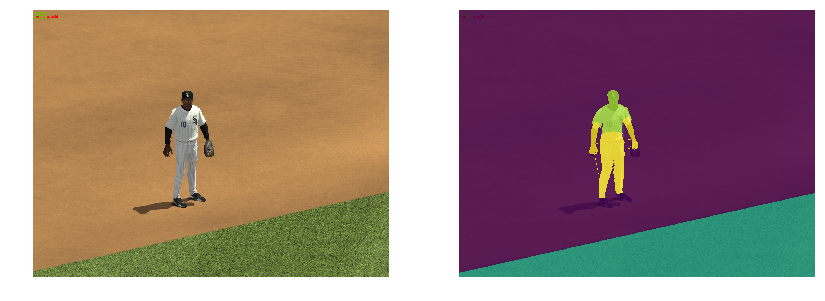

In [84]:
from scipy.misc import imsave
import matplotlib.pyplot as plt
import cv2

sshot = cv2.cvtColor(cv2.imread('shot.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread('raster.png', 0)
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(sshot)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(sshot)
plt.imshow(mask, alpha=0.8)
plt.show();plt.close()